In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt

(1383364, 2)
2025-05-02 03:58:59.622000
2025-05-02 05:59:02.048000
(1283033, 2)


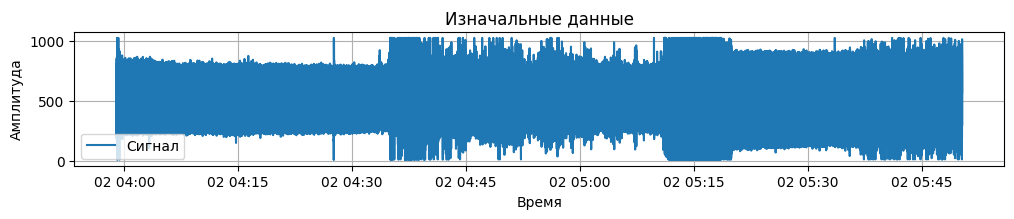

In [2]:
# Загрузка данных
data = pd.read_csv('com_data/com_data_20250502_035859_619.csv')
print(data.shape)
data.head()

# Копирование данных и преобразование времени
data = data.copy()
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
print(data['Timestamp'].min())
print(data['Timestamp'].max())

# Фильтрация данных по временному диапазону
filtered_data = data[(data['Timestamp'] > '2025-05-02 03:59:00') & 
                    (data['Timestamp'] < '2025-05-02 05:50:20')].reset_index(drop=True)

print(filtered_data.shape)

# Визуализация исходных данных
x = filtered_data['Timestamp']
y = filtered_data['COM_Data']

plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Изначальные данные")
plt.legend()
plt.grid(True)
plt.show()

# Определение пиков

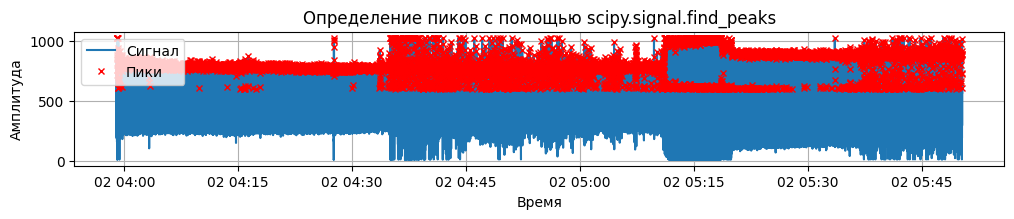

In [3]:
x = filtered_data['Timestamp']
y = filtered_data['COM_Data']


peaks, _ = find_peaks(y, height=600, distance=10, prominence=100)


# Визуализация с пиками
plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.plot(x[peaks], y[peaks], "x", color='red', label="Пики", markersize=5)
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Определение пиков с помощью scipy.signal.find_peaks")
plt.legend()
plt.grid(True)
plt.show()


# Выявление аномалий

In [ ]:
print(x[peaks])
for i in range(len(x[peaks]) - 1):
    time = pd.to_datetime(x[peaks].values)
    # Получаем полную разницу во времени в секундах
    interval = (time[i + 1] - time[i]).total_seconds()
    
    # Пересчитываем границы для BPM
    # 40 BPM = 1.5 сек между ударами
    # 150 BPM = 0.4 сек между ударами
    if not (0.4 < interval < 1.5) or (y[peaks[i]] > 850) or pd.isna(y[peaks[i]]):
        # Помечаем аномальный интервал
        mask = (filtered_data['Timestamp'] >= time[i]) & (filtered_data['Timestamp'] <= time[i + 1])
        filtered_data.loc[mask, 'COM_Data'] = None

80        2025-05-02 03:59:00.418
226       2025-05-02 03:59:01.179
351       2025-05-02 03:59:01.830
480       2025-05-02 03:59:02.502
624       2025-05-02 03:59:03.251
                    ...          
1282651   2025-05-02 05:50:18.009
1282788   2025-05-02 05:50:18.722
1282826   2025-05-02 05:50:18.920
1282896   2025-05-02 05:50:19.285
1282997   2025-05-02 05:50:19.812
Name: Timestamp, Length: 9238, dtype: datetime64[ns]


In [5]:
y[peaks[80]]

np.int64(778)

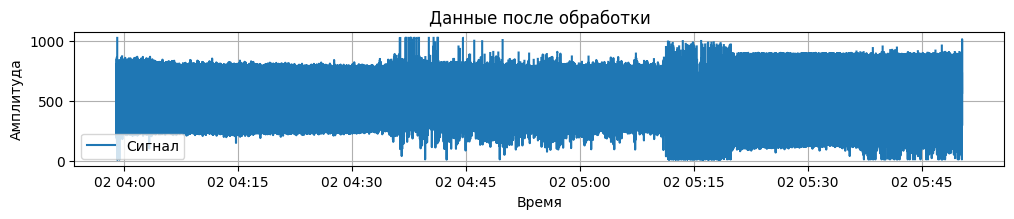

In [6]:
# Визуализация после обработки
x = filtered_data['Timestamp']
y = filtered_data['COM_Data']

plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Данные после обработки")
plt.legend()
plt.grid(True)
plt.show()

Сохранение результатов

In [7]:
filtered_data.to_csv('com_data/com_fixed_data_20250502_035859_619.csv')

(14401, 2)


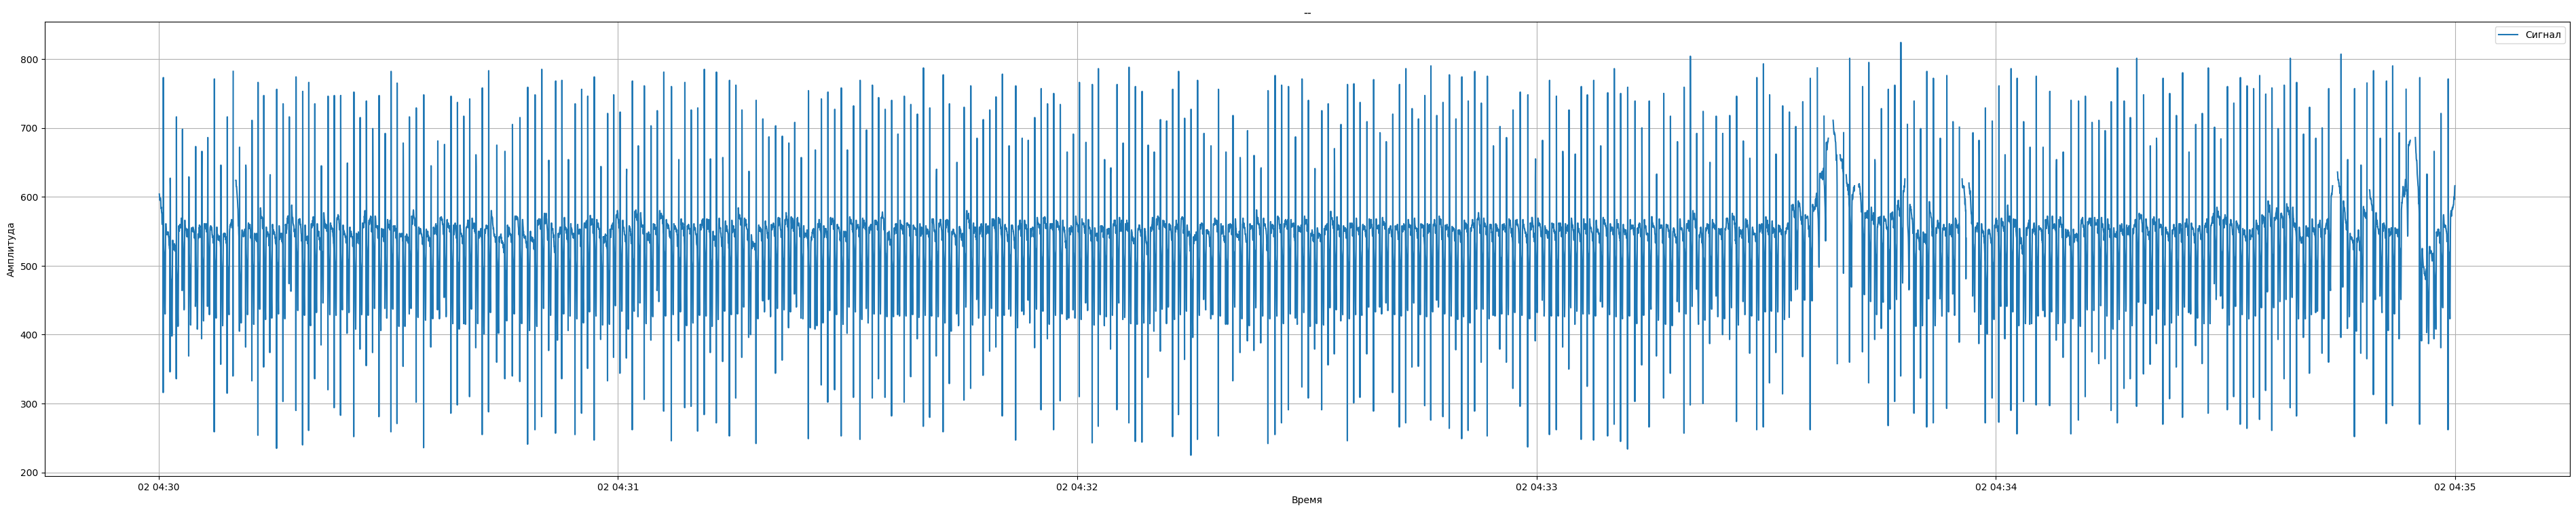

In [8]:
filtered_data1_ = filtered_data[(filtered_data['Timestamp'] > '2025-05-02 04:30:00') & 
                    (filtered_data['Timestamp'] < '2025-05-02 04:35:00')]
filtered_data1_ = filtered_data1_[0::4].reset_index(drop=True)
print(filtered_data1_.shape)

# Визуализация исходных данных
x = filtered_data1_['Timestamp']
y = filtered_data1_['COM_Data']

plt.figure(figsize=(48, 40))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("--")
plt.legend()
plt.grid(True)
plt.show()

(2880, 2)


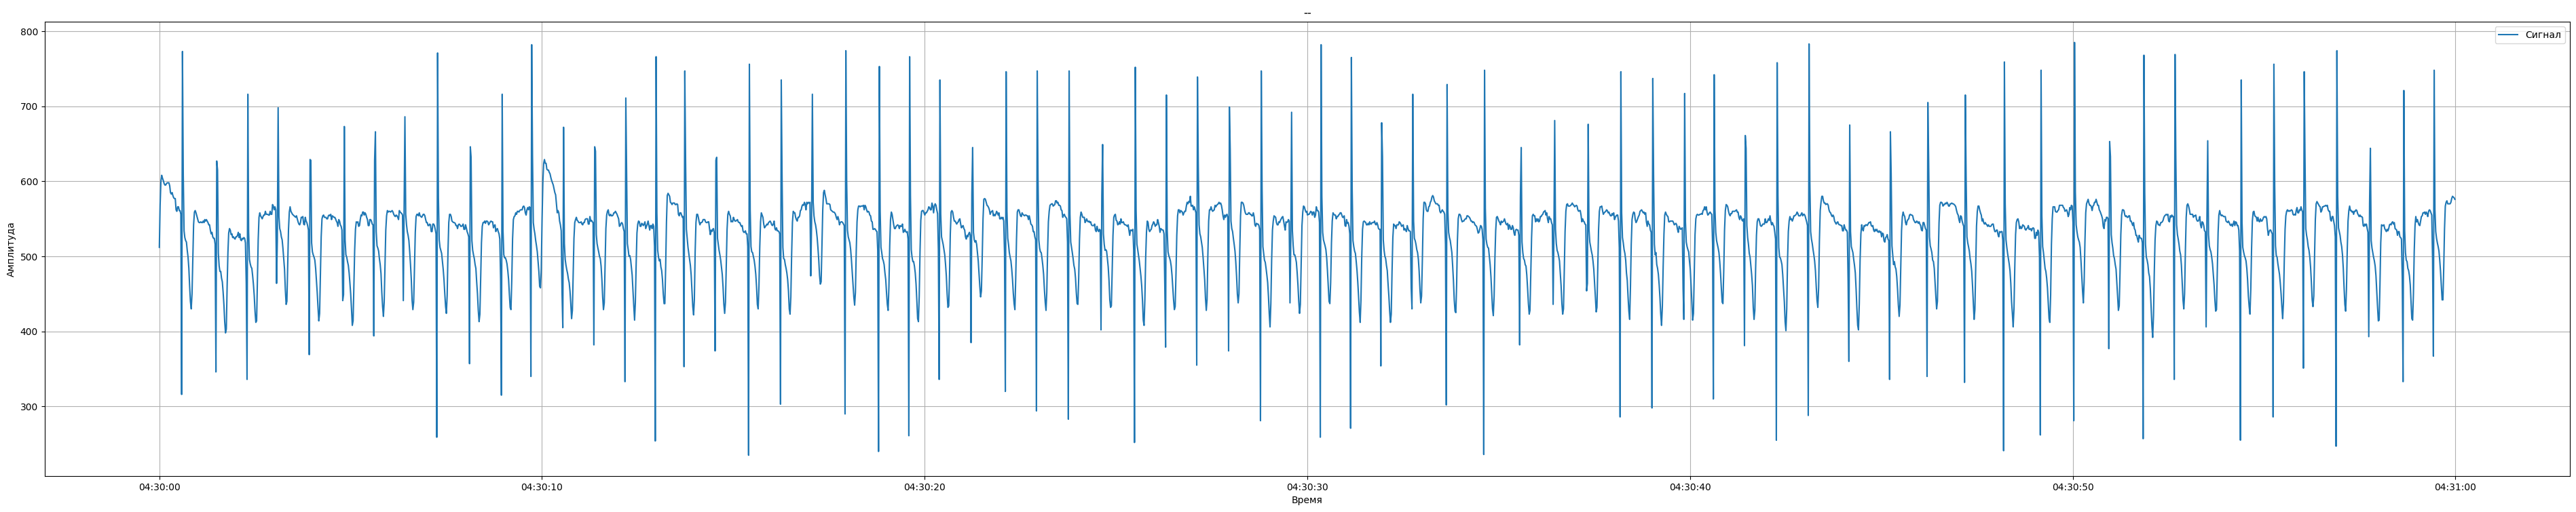

In [10]:
filtered_data1 = data[(data['Timestamp'] > '2025-05-02 04:30:00') & 
                    (data['Timestamp'] < '2025-05-02 04:31:00')]
filtered_data1 = filtered_data1[0::4].reset_index(drop=True)
print(filtered_data1.shape)

# Визуализация исходных данных
x = filtered_data1['Timestamp']
y = filtered_data1['COM_Data']

plt.figure(figsize=(48, 40))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("--")
plt.legend()
plt.grid(True)
plt.show()